<a href="https://colab.research.google.com/github/harshdhiman7/GenerativeModeling/blob/main/VAE_PyTorch_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

In [ ]:
# Parameters
img_height, img_width, img_channel = 28, 28, 1
n_batch = 128
n_epoch = 100
latent_dim = 64

In [ ]:
# Import dataset MNIST-Fashion dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1).astype("float32") / 255

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        # encoder
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(img_height, img_width, img_channel)),
            Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        # decoder
        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation="relu"),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(1, 3, activation="sigmoid", padding="same"),
        ])

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    # Build the reparameterization/sampling layer
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    # Build the decoder
    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# Train the VAE
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist, epochs= n_epoch, batch_size= n_batch)

Epoch 1/100
547/547 [==============================] - 13s 9ms/step - loss: 373.7294 - reconstruction_loss: 320.4773 - kl_loss: 10.5634
Epoch 2/100
547/547 [==============================] - 5s 9ms/step - loss: 289.1246 - reconstruction_loss: 274.6359 - kl_loss: 9.6697
Epoch 3/100
547/547 [==============================] - 4s 8ms/step - loss: 276.4321 - reconstruction_loss: 267.6748 - kl_loss: 7.7600
Epoch 4/100
547/547 [==============================] - 4s 8ms/step - loss: 271.2888 - reconstruction_loss: 264.1487 - kl_loss: 6.9628
Epoch 5/100
547/547 [==============================] - 5s 9ms/step - loss: 269.7942 - reconstruction_loss: 262.4338 - kl_loss: 6.7080
Epoch 6/100
547/547 [==============================] - 4s 8ms/step - loss: 267.9921 - reconstruction_loss: 261.1059 - kl_loss: 6.6441
Epoch 7/100
547/547 [==============================] - 5s 9ms/step - loss: 267.1839 - reconstruction_loss: 260.1518 - kl_loss: 6.6144
Epoch 8/100
547/547 [==============================] - 5s 9m

In [ ]:
# Display a grid of sampled classes
def plot_latent_space(vae, n=30, figsize=15):
    img_height = 28
    scale = 1.0
    figure = np.zeros((img_height * n, img_height * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            classes = x_decoded[0].reshape(img_height, img_height)
            figure[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
            ] = classes

    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z[0]")
    plt.ylabel("variance, z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 64), found shape=(None, 2)


1875/1875 [==============================] - 3s 2ms/step


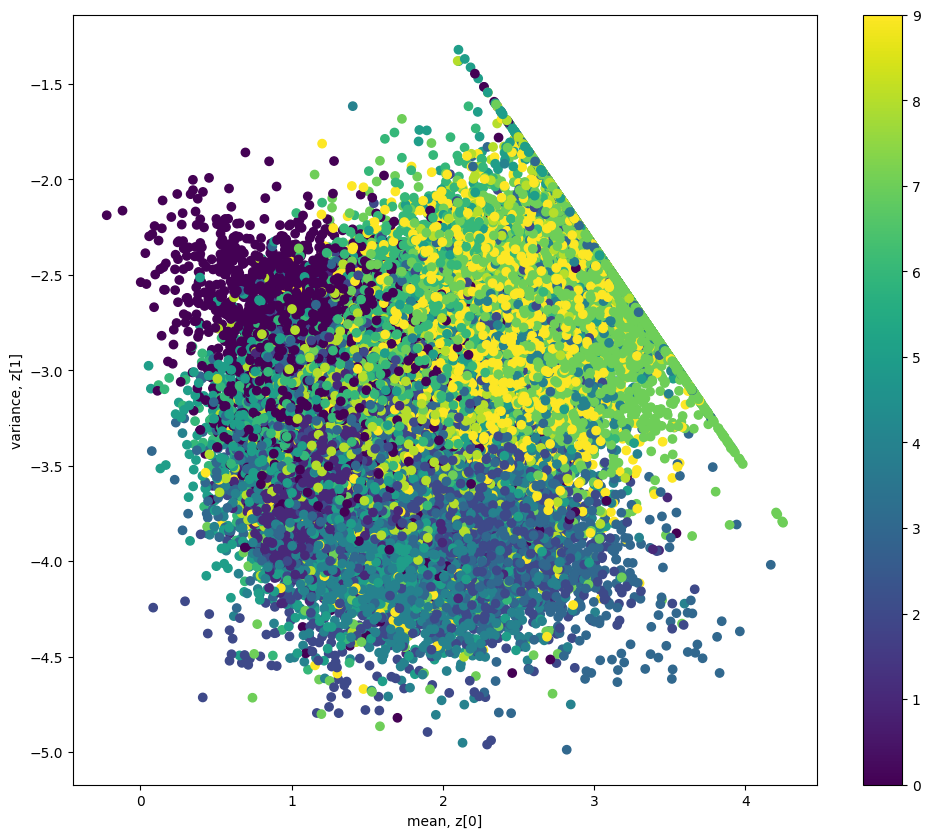

In [ ]:
# Display how the latent space clusters different data classes
def plot_label_clusters(vae, data, labels):
    z_mean= vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("mean, z[0]")
    plt.ylabel("variance, z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

#VAE with PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # Decoder layers
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Initialize the VAE model
input_size = 784  # MNIST images are 28x28
hidden_size = 400
latent_size = 20
vae = VAE(input_size, hidden_size, latent_size)

# Set up DataLoader for MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

# Define optimizer
optimizer = optim.Adam(vae.parameters(), lr=3e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)
        data = Variable(data)

        optimizer.zero_grad()

        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()

        optimizer.step()

    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, loss.item()))

# After training, you can sample from the learned latent space to generate new images


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1, Loss: 14994.2568
Epoch: 2, Loss: 12602.3350
Epoch: 3, Loss: 12647.6621
Epoch: 4, Loss: 11137.7617
Epoch: 5, Loss: 10660.5625
Epoch: 6, Loss: 10728.7852
Epoch: 7, Loss: 11341.3281
Epoch: 8, Loss: 10877.2715
Epoch: 9, Loss: 10951.3750
Epoch: 10, Loss: 10336.6318
